In [27]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import warnings
from numba import NumbaDeprecationWarning

warnings.filterwarnings(
    "ignore",
    message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
    category=FutureWarning,
)
warnings.filterwarnings(
    "ignore",
    message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
    category=FutureWarning,
)
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

In [30]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

In [31]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [32]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [33]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 9) (16512, 1)
(4128, 9) (4128, 1)


In [34]:
reports.data_exploration(train_X,train_y,'reports/data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


# Feature preprocessing

In [35]:
housing_num = train_X.drop("ocean_proximity", axis=1)
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.87,38.48,27.0,3894.0,776.0,1832.0,715.0,3.5085
1,-118.34,34.02,49.0,1609.0,371.0,896.0,389.0,2.5156
2,-122.42,37.79,52.0,3364.0,1100.0,2112.0,1045.0,2.1343
3,-119.08,35.32,8.0,11609.0,2141.0,5696.0,2100.0,5.0012
4,-121.62,41.78,40.0,3272.0,663.0,1467.0,553.0,1.7885
...,...,...,...,...,...,...,...,...
16507,-116.93,33.73,13.0,3603.0,573.0,1644.0,515.0,4.0433
16508,-117.27,33.77,16.0,2876.0,576.0,1859.0,545.0,2.0878
16509,-121.98,37.22,46.0,10088.0,1910.0,3728.0,1781.0,5.2321
16510,-118.08,33.88,26.0,1507.0,270.0,931.0,275.0,5.1645


In [36]:
housing_categorical = train_X[["ocean_proximity"]]
housing_categorical

,ocean_proximity
0,<1H OCEAN
1,<1H OCEAN
2,NEAR BAY
3,INLAND
4,INLAND
...,...
16507,INLAND
16508,<1H OCEAN
16509,<1H OCEAN
16510,<1H OCEAN


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X.iloc[:, rooms_ix] / X.iloc[:, households_ix]
        population_per_household = X.iloc[:, population_ix] / X.iloc[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X.iloc[:, bedrooms_ix] / X.iloc[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [38]:
num_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_trans = num_pipeline.fit_transform(housing_num)

In [39]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_X_prepro = full_pipeline.fit_transform(train_X)
test_X_prepro = full_pipeline.transform(test_X)

In [40]:
lin_reg = SKLStatsmodelOLS()
lin_reg.fit(train_X_prepro, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


SKLStatsmodelOLS()

In [41]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     1917.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        11:29:37   Log-Likelihood:            -2.0723e+05
No. Observations:               16512   AIC:                         4.145e+05
Df Residuals:                   16495   BIC:                         4.146e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.048e+15   1.38e+16     -0.510      0.610   -3.41e+16       2e+16
0          -5.573e+04   2296.059    -24.271      0.000   -6.02e+04   -5.12e+04
1          -5.676e+04   2419.526    -23.459      0.000   -6.15e+04    -5.2e+04
2           1.349e+04    610.958     22.074      0.000    1.23e+04    1.47e+04
3             95.0175   2172.254      0.044      0.965   -4162.834    4352.869
4           3087.5231   3361.715      0.918      0.358   -3501.800    9676.846
5          -4.528e+04   1357.962    -33.341      0.000   -4.79e+04   -4.26e+04
6           4.736e+04   3296.298     14.368      0.000    4.09e+04    5.38e+04
7           7.558e+04    757.785     99.735      0.000    7.41e+04    7.71e+04
8           7788.0711    700.327     11.121      0.000    6415.355    9160.787
9             66.9233    546.932      0.122      0.903   -1005.122    1138.968
10          1.183e+04    825.192     14.333      0.000    1.02e+04    1.34e+04
11          7.048e+15   1.38e+16      0.510      0.610      -2e+16    3.41e+16
12          7.048e+15   1.38e+16      0.510      0.610      -2e+16    3.41e+16
13          7.048e+15   1.38e+16      0.510      0.610      -2e+16    3.41e+16
14          7.048e+15   1.38e+16      0.510      0.610      -2e+16    3.41e+16
15          7.048e+15   1.38e+16      0.510      0.610      -2e+16    3.41e+16
==============================================================================
Omnibus:                     4029.379   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16104.316
Skew:                           1.163   Prob(JB):                         0.00
Kurtosis:                       7.242   Cond. No.                     1.26e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.08e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
reg_linear_report = RegressionReport(model=lin_reg, x_train=train_X_prepro, y_train=train_y, x_test= test_X_prepro, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='reports/regression_linear_model_report')

In [43]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_X_prepro, train_y)

DecisionTreeRegressor()

In [44]:
reg_linear_report = RegressionReport(model=lin_reg, x_train=train_X_prepro, y_train=train_y, x_test= test_X_prepro, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='reports/dt_model_report')

In [45]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train_X_prepro, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [46]:
cols = list(train_X.drop("ocean_proximity", axis=1).columns) + ["rooms_per_household", "population_per_household",
                         "bedrooms_per_room"] + list(full_pipeline.transformers_[1][1].get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


<AxesSubplot:>

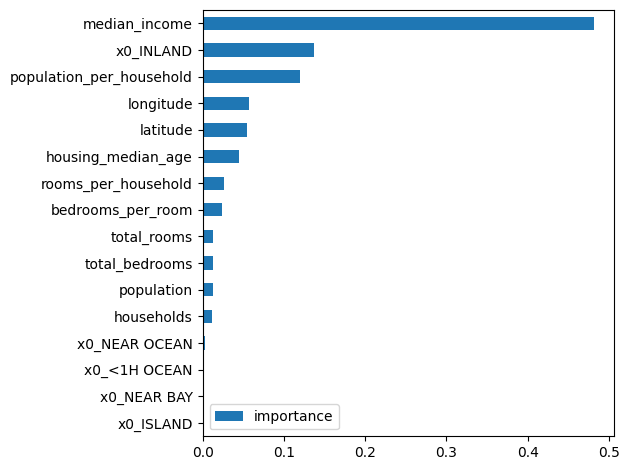

In [47]:
%matplotlib inline
imp = pd.DataFrame({'importance': forest_reg.feature_importances_})
imp.index = cols
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 5, 10], 'max_features': [2, 4, 5]},
    {'bootstrap': [False], 'n_estimators': [3,8], 'max_features': [1,2,3]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_X_prepro, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 5],
                          'n_estimators': [3, 5, 10]},
                         {'bootstrap': [False], 'max_features': [1, 2, 3],
                          'n_estimators': [3, 8]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [49]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-2718182104.937421
{'max_features': 5, 'n_estimators': 10}


In [50]:
train_y["median_house_value"].values[0] = train_y["median_house_value"].values[0] + 0.01
train_y["median_house_value"].values[0]

187800.01

In [51]:
models_list = [lin_reg, tree_reg, grid_search.best_estimator_]

model_comparison_report = RegressionComparison(models=models_list,x=train_X_prepro, y=train_y["median_house_value"].values)
metrics = model_comparison_report.get_report(file_path='reports/regression_comparison')

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names


In [52]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
SKLStatsmodelOLS,0.2858,0.2387,49337.2481,68285.7836,0.6503
DecisionTreeRegressor,0.0000,0.0000,0.0000,0.0001,1.0000
RandomForestRegressor,0.0764,0.0673,13902.1796,22313.3319,0.9627
